- **Author:** [Dace Apšvalka](https://www.mrc-cbu.cam.ac.uk/people/dace.apsvalka/) 
- **Date:** August 2024  
- **conda environment**: I used the [fMRI workshop's conda environment](https://github.com/MRC-CBU/COGNESTIC/blob/main/mri_environment.yml) to run this notebook and any accompanied scripts.

# fMRI Data Analysis: Group-Level Analysis

Once you have beta (or contrast) maps for conditions (or contrasts) from all subjects, you can perform group-level statistics. Importantly, all subject first-level results need to be in common space, e.g., MNI, to perform voxel-wise group analyses. Group-level analysis allows you to make inferences about the population, rather than individual subjects, by assessing common patterns across participants. Common statistical methods for group-level analysis include one-sample or paired t-tests, as well as more complex mixed-effects models, depending on your study design.

In this tutorial, we are adopting a **mixed-effects model** approach. We will incorporate the beta maps of all nine conditions into a single design matrix with subject-specific regressors. This approach can capture more of the explained variance by accounting for both condition effects and subject-level variability in one model. This differs from a one-sample t-test on first-level contrast estimates, where the model only assesses the variance in the contrast across subjects. The one-sample t-test simplifies the analysis but doesn't explicitly model within-subject variability or interactions across conditions, which can lead to a less comprehensive understanding of the underlying effects. The mixed-effects model approach handles both within- and between-subject variability, allowing for a more nuanced analysis of comparisons and potentially reducing unexplained variance.

Mixed-effects models are often analysed with ANOVA, which Nilean's `second_level_model.compute_contrast` would do. However, there isn’t a straightforward way with Nilearn to check and account for non-sphericity in the data *(see [Rik’s Stats tutorial](../02_Statistics/cognestic_stats_python.ipynb) on ANOVA for the importance of this)*. To mitigate this issue, we can use Nilearn's non-parametric inference, which we will employ for our final results in this group-level analysis example.

Here is a recommended viewing to help better understand the principles of the group-level analysis:

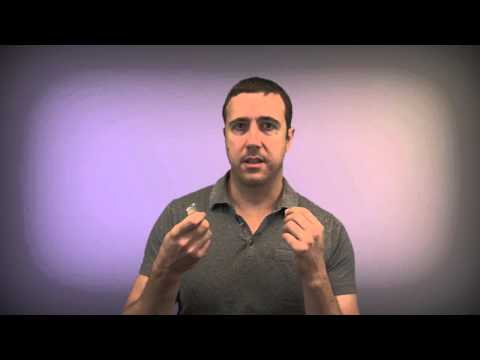

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('__cOYPifDWk', width=560, height=315)


---------------

**Table of contents**   
1. Import required packages and set up some stuff   
2. Retrieve First-Level results   
3. Displaying subject Effects-Of-Interest z-maps   
4. Specify the second-level model  
4.1. Design matrix   
4.2. Contrasts   
4.3. Model specification and fit 
5. Computing contrasts and plotting result maps
5.1. False-positive-rate with cluster-forming threshold    
5.2. FWE correction using Bonferroni correction 
5.3. FWE correction using non-parametric permutation testing    
6. Summary results  
6.1. Using atlasreader package    
6.2. Nilearn's report 

-----
## Import required packages and set up some stuff

In [ ]:
# The conda environment used for this tutorial is available here: https://github.com/MRC-CBU/COGNESTIC/blob/main/mri_environment.yml 

import os.path as op # for file path operations
import glob # to search for files using regex

import pandas as pd # for data manipulation
import numpy as np # for numerical operations

from bids.layout import BIDSLayout # to fetch data from BIDS-compliant datasets

import matplotlib.pyplot as plt # for basic plotting

import nibabel as nib # NiBabel, to read and write neuroimaging data, https://nipy.org/nibabel/

# Nilearn modules, for the analysis of brain volumes, plotting, etc., https://nilearn.github.io/
from nilearn.plotting import plot_glass_brain, plot_design_matrix, plot_contrast_matrix, plot_stat_map, view_img, view_img_on_surf
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm.thresholding import threshold_stats_img
from nilearn.datasets import load_mni152_template
from nilearn.glm.second_level import non_parametric_inference

from atlasreader import create_output # For generating result tables https://github.com/miykael/atlasreader

In [ ]:
# MNI152 template will be used as a backgound for plotting MNI-space ROIs
mni152_template = load_mni152_template()

## Retrieve First-Level results

For the group analysis, we will use the single-condition contrast estimate (beta estimate) maps for all nine conditions. Because we saved the results in BIDS format, we can us PyBIDS to retrieve the subject-level results. 

In [ ]:
# --- Set up the paths to the data and results folders
fmri_data_dir = 'FaceProcessing/data' # data in BIDS format
fmri_results_dir = 'FaceProcessing/results' # results in BIDS format

# --- Set up the BIDS layout
layout = BIDSLayout(fmri_data_dir, derivatives = True)

# Attach the results folder to the layout. It must complay with BIDS standards. 
# And must include dataset_description.json file!
layout.add_derivatives(op.join(fmri_results_dir, "first-level"))

Specify which conditions to include in the analysis and retrieve their effect files from the first-level results.

In [ ]:
conditions = ['FAMOUS1', 'FAMOUS2dl', 'FAMOUS2im', 'UNFAMILIAR1', 'UNFAMILIAR2dl', 'UNFAMILIAR2im', 'SCRAMBLED1', 'SCRAMBLED2dl', 'SCRAMBLED2im']

effect_files = layout.get(desc=conditions, suffix='effect', extension='.nii.gz', return_type='filename')

# print to see if it found what we expexted
print(f"Found {len(effect_files)} effect files:")
print(*effect_files, sep="\n")

## Displaying subject Effects-Of-Interest z-maps

To check how the first-level results look overall, it is helpful to display effects-of-interest for all subjects. 

In [ ]:
eoi_maps = layout.get(desc='EffectsOfInterest', extension='.nii.gz', return_type='file')
print(*eoi_maps, sep="\n")

In [ ]:
subjects = layout.get_subjects()

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(14, 14))

for i, stat_map in enumerate(eoi_maps):
    plot_glass_brain(stat_map, 
                              title = 'sub-' + subjects[i],
                              axes = axes[int(i / 4), int(i % 4)],
                              plot_abs = False, 
                              display_mode='x')
fig.suptitle('Effects of interest' + ', unthresholded z-maps')

## Specify the second-level model

At the group-level analysis, we also use a GLM. The outcome variable is the beta/contrast estimate from each subject, and the predictor variables typically include group-level factors such as experimental conditions, subject-specific regressors (in repeated-measures designs), group-specific regressors (in between-subject designs), and subject-specific covariates (e.g., age, gender, or behavioural scores).

### Design matrix

In this example, the design matrix we generate will represent a mixed-effects design, incorporating both **within-subject (conditions)** and **between-subject (subjects)** factors. Each row in the design matrix corresponds to a specific observation, which in this case is a beta estimate from a given condition and subject, while each column represents a predictor variable.

The number of rows in the design matrix must match the number of first-level result files that will be entered into the second-level model. The order of the rows in the design matrix must match the order of the provided files.


In [ ]:
conditions = ['FAMOUS1', 'FAMOUS2dl', 'FAMOUS2im', 'UNFAMILIAR1', 'UNFAMILIAR2dl', 'UNFAMILIAR2im', 'SCRAMBLED1', 'SCRAMBLED2dl', 'SCRAMBLED2im']

# Create an empty DataFrame
df = pd.DataFrame(columns=conditions + subjects)

# Populate the DataFrame with 0s and 1s
for i, condition in enumerate(conditions):
    # Filter files based on condition
    condition_files = [1 if condition in file else 0 for file in effect_files]
    # Add a column for the condition
    df[condition] = condition_files

# Populate the DataFrame with 0s and 1s for subjects
for i, subject in enumerate(subjects):
    # Filter files based on subject
    subject_files = [1 if f"sub-{subject}" in file else 0 for file in effect_files]
    # Add a column for the subject
    df[subject] = subject_files

# Print the resulting DataFrame
design_matrix = df
design_matrix

In [ ]:
ax = plot_design_matrix(design_matrix)
ax.set_title("Second level design matrix", fontsize=12)
ax.set_ylabel("stat maps")

### Contrasts

For these group-level results, we are only interested in the statistics, not the contrast estimates, so scaling the contrasts is not strictly necessary.

In [ ]:
n_columns = design_matrix.shape[1]

contrasts = {
  'Faces_Scrambled': np.pad([1, 1, 1, 1, 1, 1, -2, -2, -2], (0, n_columns - 9), 'constant'),
  'Famous_Unfamiliar': np.pad([1, 1, 1, -1, -1, -1, 0, 0, 0], (0, n_columns - 9), 'constant')
}


In [ ]:
for contrast_id, contrast_val in contrasts.items():
    plot_contrast_matrix(contrast_val, design_matrix=design_matrix)
    plt.suptitle(contrast_id)

### Model specification and fit

In [ ]:
# specify
second_level_model = SecondLevelModel() 
# fit
second_level_model = second_level_model.fit(
  effect_files, 
  design_matrix = design_matrix
  )

## Computing contrasts and plotting result maps

In [ ]:
# get the z-maps for the contrast
z_map = second_level_model.compute_contrast(
  contrasts['Faces_Scrambled'], 
  output_type='z_score')

### False-positive-rate with cluster-forming threshold

In [ ]:
thresholded_map_fpr, threshold_fpr = threshold_stats_img(
  z_map, 
  alpha=0.001, 
  height_control='fpr', 
  cluster_threshold=20,
  two_sided=True)


In [ ]:
print('Uncorrected p<.001 threshold: %.3f' % threshold_fpr)

plot_stat_map(
    thresholded_map_fpr,
    bg_img = mni152_template, 
    threshold=threshold_fpr,   
    display_mode = 'ortho',
    black_bg = True,    
    title = 'Faces > Scrambled  (p<.001, uncorrected, k=20)'
    )

fig = plt.gcf()
fig.set_size_inches(10,3)
plt.show()

In [ ]:
# Interactive plotting
plot = view_img(
  thresholded_map_fpr, 
  bg_img=mni152_template, 
  threshold=threshold_fpr, 
  colorbar=True, 
  title='Faces > Scrambled  (p < .001, uncorrected)'
  )

plot.open_in_browser()

### FWE correction using Bonferroni correction

In [ ]:
thresholded_map_bonf, threshold_bonf = threshold_stats_img(
  z_map, 
  alpha=0.05, 
  height_control='bonferroni', 
  cluster_threshold=20,
  two_sided=False)

print('Bonferroni p<.05 threshold: %.3f' % threshold_bonf)

plot_stat_map(
    thresholded_map_bonf, 
    bg_img = mni152_template,
    threshold=threshold_bonf,   
    display_mode = 'ortho',
    black_bg = True,
    cmap = 'hot',    
    title = 'Faces > Scrambled  (Bonf. p<.05, k=20)'
    )

fig = plt.gcf()
fig.set_size_inches(10,3)
plt.show()

### FWE correction using non-parametric permutation testing

Nilearn's FWE correction using the Bonferroni approach (`height_control='bonferroni'`) is applied to the number of voxels. However, this method is not well-suited for fMRI data because neuroimaging data typically exhibit spatially correlated data points, which violate the Bonferroni assumption of independent tests.

As an alternative, neuroscientists have developed **Random Field Theory** (RFT), which accounts for spatial correlations by applying multiple comparison corrections that consider the smoothness of the data. Specifically, the correction is applied to the number of **'resels'** (RESolution ELements), rather than the raw number of voxels. However, it's important to note that this RFT-based approach is not implemented in Nilearn. At the group level, Nilearn provides an option for non-parametric inference with permutation testing, which is a more appropriate approach for fMRI data when accounting for the spatial correlation of voxels.

*(More on non-parametric permutation testing, have a look at [Rik's Stats notebook](../02_Statistics/cognestic_stats_python.ipynb).)*

In [ ]:
out_dict = non_parametric_inference(
    effect_files,
    design_matrix = design_matrix,
    second_level_contrast = contrasts['Faces_Scrambled'],
    n_perm = 100, # ideally at least 10000
    two_sided_test = False,
    n_jobs = -1, # Use all available cores
    threshold = 0.001 # cluster level threshold; enables cluster-level inference
)

# Print the keys of the output dictionary
print(out_dict.keys())

The output is multiple images (maps), organised in a dictionary. 
* Voxel-level inference
  * **t**: t-statistics
  * **logp_max_t**: Negative log10 family-wise error rate-corrected p-values corrected based on the distribution of maximum t-statistics from permutations.
* Cluster-level inference
  * **size**: Cluster size values associated with the significance test 
  * **logp_max_size**: Negative log10 family-wise error rate-corrected p-values corrected based on the distribution of maximum cluster sizes from permutations.
  * **mass**: Cluster mass values associated with the significance test 
  * **logp_max_mass**: Negative log10 family-wise error rate-corrected p-values corrected based on the distribution of maximum cluster masses from permutations. 

**We will focus only on the voxel-level inference.**

To report the FWE-corrected maps, we could display the *logp_max_t*; however, these values can be difficult to interpret if you're not familiar with them. It might be better to plot and report a t-map, masked to exclude the voxels that did not survive the FWE correction.

Let's create a new image displaying t-values for the voxels with a p-value < 0.05.

In [ ]:
alpha = 0.05
masked = out_dict['logp_max_t'].get_fdata() > -np.log10(alpha)
masked_t_map = out_dict['t'].get_fdata() * masked

# save the masked t-map as a nifti image
masked_t_map_img = nib.Nifti1Image(masked_t_map, out_dict['t'].affine)

In [ ]:
# Get the smallest t-value that is above the threshold (for the colorbar; the maps themselves are thresholded already)
threshold_fwe = masked_t_map[masked_t_map > 0].min()
print('FWE (perm.) p<.05 threshold: %.3f' % threshold_fwe)

plot_stat_map(
    masked_t_map_img, 
    threshold = threshold_fwe,       
    display_mode = 'ortho',
    black_bg = True,
    bg_img = mni152_template,
    cmap = 'hot',
    title = f"Faces > Scrambled (FWE p <.{alpha})")

fig = plt.gcf()
fig.set_size_inches(10,3)
plt.show()

In this example, we observe that the non-parametric FWE correction is slightly less conservative than the Bonferroni correction.

## Summary results

### Using atlasreader package

We can use ['atlasreader'](https://github.com/miykael/atlasreader) package to get summary results (peak table, cluster table, .png images of each cluster). 

In [ ]:
# generate and save atlasreader output
outdir = op.join(fmri_results_dir, 'group-level', 'permutation', 'FacesScrambled')

create_output(
    masked_t_map_img, 
    cluster_extent = 20, 
    voxel_thresh = threshold_fwe,
    direction = 'pos',
    outdir = outdir
)

In [ ]:
# display the peak table
peaks = glob.glob(op.join(outdir, '*_peaks.csv'))
display(pd.read_csv(peaks[0]))

In [ ]:
# display the cluster table
clusters = glob.glob(op.join(outdir, '*_clusters.csv'))
display(pd.read_csv(clusters[0]))

**Some more plotting options**

In [ ]:
# get the top 5 peaks' x values
x = pd.read_csv(peaks[0])['peak_x'][:5]
# sort the x values
x = x.sort_values()

# plot these peaks
plot_stat_map(
    masked_t_map_img, 
    threshold = threshold_fwe,       
    display_mode = 'x',
    cut_coords = x,
    black_bg = True,
    bg_img = mni152_template,
    cmap = 'hot',
    title = f"Faces > Scrambled (FWE p <.{alpha})")

fig = plt.gcf()
fig.set_size_inches(15,3)

We can also look at a 3D brain using `plotly`.

In [ ]:
view = view_img_on_surf(masked_t_map_img, 
    threshold = threshold_fwe)
#view.open_in_browser()
view.resize(1600, 800)
view

Or use, for example, FSLeyes to plot and explore the result maps. 

### Nilearn's report

Nilearn has a built-in report generator that can create reports for all defined contrasts. However, a limitation is that it cannot generate reports for results obtained using non-parametric inference.

In [ ]:
second_level_report = second_level_model.generate_report(
  contrasts, 
  title = "Results of the second-level analysis", 
  bg_img = mni152_template, 
  alpha = 0.001, 
  cluster_threshold = 20, 
  height_control = 'fpr', 
  min_distance = 8.0, 
  plot_type = 'slice', 
  display_mode = 'x', 
  report_dims = (1600, 800))

second_level_report.open_in_browser()

#second_level_report.save_as_html(file_name)

# EXCERCISE

Perform a one-sample t-test on the first-level results of *Faces > Scrambled* contrast. How do the results compare to our mixed-effect model approach above? 